In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=c4fecb2308ecddeaf8b708d9d24e175c141a16b6d913f51282736dd793d46baa
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [ ]:
spark = SparkSession.builder.appName("spark").getOrCreate()

In [ ]:
df=spark.read.csv("Diabetes.csv",header=True,inferSchema=True)

In [ ]:
columns = df.columns
for column in columns:
    print(column)

age
hypertension
heart_disease
bmi
HbA1c_level
blood_glucose_level
diabetes


In [ ]:
df.show()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|         

In [ ]:
df.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
print(("Rows=",df.count(),"Columns=",len(df.columns)))

('Rows=', 100000, 'Columns=', 7)


In [ ]:
df.groupBy("diabetes").count().show()

+--------+-----+
|diabetes|count|
+--------+-----+
|       1| 8500|
|       0|91500|
+--------+-----+



In [ ]:
df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+
|summary|              age|      hypertension|     heart_disease|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+-----------------+------------------+------------------+-----------------+------------------+-------------------+-------------------+
|  count|           100000|            100000|            100000|           100000|            100000|             100000|             100000|
|   mean|41.88585600000013|           0.07485|           0.03942|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|22.51683987161704|0.2631504702289171|0.1945930169980986|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|    min|             0.08|                 0|                 0|            10.01|               3.5|                 80|                  0|

In [ ]:
for col in df.columns:
  print(col+":",df[df[col].isNull()].count())

age: 0
hypertension: 0
heart_disease: 0
bmi: 0
HbA1c_level: 0
blood_glucose_level: 0
diabetes: 0


In [ ]:
def count_zeros():
  col=["hypertension","heart_disease","bmi","HbA1c_level","blood_glucose_level"]
  for i in col:
    print(i+":",df[df[i]==0].count())
count_zeros()


hypertension: 92515
heart_disease: 96058
bmi: 0
HbA1c_level: 0
blood_glucose_level: 0


In [ ]:
from pyspark.sql.functions import *
for i in df.columns[1:6]:
  data=df.agg({i:"mean"}).first()[0]
  print("Mean for {} is {}".format(i,data))
  df=df.withColumn(i,when(df[i]==0,int(data)).otherwise(df[i]))
df.show()

Mean for hypertension is 0.07485
Mean for heart_disease is 0.03942
Mean for bmi is 27.32076709999422
Mean for HbA1c_level is 5.5275069999983275
Mean for blood_glucose_level is 138.05806
+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.

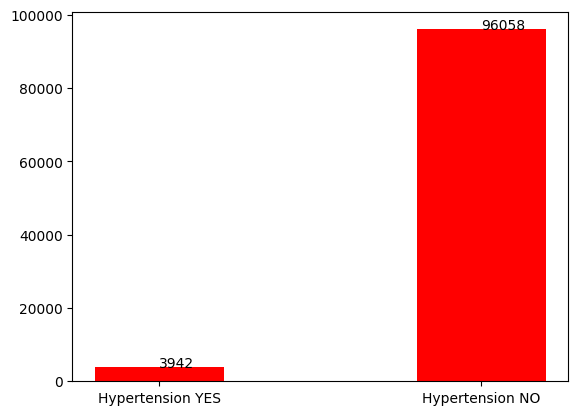

In [ ]:
import matplotlib.pyplot as plt
rdd2=df.rdd.map(lambda x:(str(x[2]),1)).reduceByKey(lambda x,y:x+y)

x=[rdd2.collect()[0][1],rdd2.collect()[1][1]]
y=["Hypertension YES","Hypertension NO"]
plt.bar(y,x,color="red",width=0.4)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,x[i],x[i])
addlabels(x,y)
plt.show()

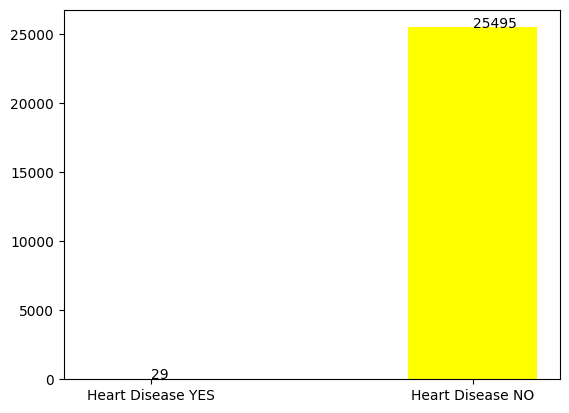

In [ ]:
rdd2=df.rdd.map(lambda x:(str(x[3]),1)).reduceByKey(lambda x,y:x+y)
x=[rdd2.collect()[0][1],rdd2.collect()[1][1]]
y=["Heart Disease YES","Heart Disease NO"]
plt.bar(y,x,color="yellow",width=0.4)
def addlabels(y,x):
    for i in range(len(x)):
        plt.text(i,x[i],x[i])
addlabels(y,x)
plt.show()

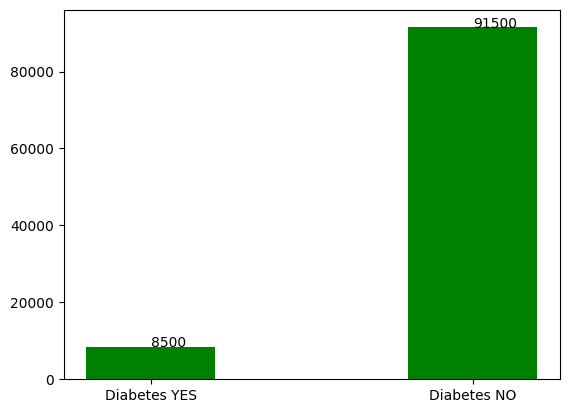

In [ ]:
rdd2=df.rdd.map(lambda x:(str(x[6]),1)).reduceByKey(lambda x,y:x+y)

x=[rdd2.collect()[1][1],rdd2.collect()[0][1]]
y=["Diabetes YES","Diabetes NO"]
plt.bar(y,x,color="green",width=0.4)
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,x[i],x[i])
addlabels(x,y)
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=["hypertension","heart_disease","bmi","HbA1c_level","blood_glucose_level","age"],outputCol='features')
outputfeatures=assembler.transform(df)
outputfeatures.printSchema()

root
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)
 |-- features: vector (nullable = true)



In [ ]:
outputfeatures.show()

+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|            features|
+----+------------+-------------+-----+-----------+-------------------+--------+--------------------+
|80.0|           0|            1|25.19|        6.6|                140|       0|[0.0,1.0,25.19,6....|
|54.0|           0|            0|27.32|        6.6|                 80|       0|[0.0,0.0,27.32,6....|
|28.0|           0|            0|27.32|        5.7|                158|       0|[0.0,0.0,27.32,5....|
|36.0|           0|            0|23.45|        5.0|                155|       0|[0.0,0.0,23.45,5....|
|76.0|           1|            1|20.14|        4.8|                155|       0|[1.0,1.0,20.14,4....|
|20.0|           0|            0|27.32|        6.6|                 85|       0|[0.0,0.0,27.32,6....|
|44.0|           0|            0|19.31|        6.5|                200|       1|[0

In [ ]:
from pyspark.ml.classification import LogisticRegression
#selecting only relevant columsn to train our model
finalData=outputfeatures.select("features","diabetes")
finalData.printSchema()
train,test=finalData.randomSplit([0.7,0.3])
#creating model
models=LogisticRegression(labelCol="diabetes")
model=models.fit(train)

root
 |-- features: vector (nullable = true)
 |-- diabetes: integer (nullable = true)



In [ ]:
summary=model.summary
summary.predictions.describe().show()

+-------+-------------------+--------------------+
|summary|           diabetes|          prediction|
+-------+-------------------+--------------------+
|  count|              69980|               69980|
|   mean|0.08649614175478708|0.062474992855101455|
| stddev| 0.2810972933602803| 0.24201798510632955|
|    min|                0.0|                 0.0|
|    max|                1.0|                 1.0|
+-------+-------------------+--------------------+



In [ ]:
#Evaluation and model testing
from pyspark.ml.evaluation import BinaryClassificationEvaluator
newpredictions=model.evaluate(test)
newpredictions.predictions.show()


+--------------------+--------+--------------------+--------------------+----------+
|            features|diabetes|       rawPrediction|         probability|prediction|
+--------------------+--------+--------------------+--------------------+----------+
|[0.0,0.0,10.01,6....|       0|[7.24707828015705...|[0.99928825458876...|       0.0|
|[0.0,0.0,10.3,5.7...|       0|[7.67239497612588...|[0.99953471496861...|       0.0|
|[0.0,0.0,10.5,4.8...|       0|[9.41199177920048...|[0.99991826869945...|       0.0|
|[0.0,0.0,10.62,3....|       0|[11.3885016546887...|[0.99998867517092...|       0.0|
|[0.0,0.0,10.86,6....|       0|[6.54116327921820...|[0.99855926956648...|       0.0|
|[0.0,0.0,10.86,6....|       0|[8.16059723650143...|[0.99971438987813...|       0.0|
|[0.0,0.0,10.91,3....|       0|[15.0427759282277...|[0.99999970690710...|       0.0|
|[0.0,0.0,10.91,6....|       0|[3.93480711313937...|[0.98082538378101...|       0.0|
|[0.0,0.0,11.01,6....|       0|[6.84476212593353...|[0.9989361135

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol='diabetes')
evaluator.evaluate(model.transform(test))

0.9610113101557473

In [ ]:
model.save("LRModel")

In [ ]:
#Loading the model built and using it for prediction
from pyspark.ml.classification import LogisticRegressionModel
lr = LogisticRegressionModel.load('LRModel')

In [ ]:
pip install findspark

In [ ]:
import time

In [ ]:
start_time = time.time()
lr.fit(X_train, y_train)
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Elapsed time: 0.12 seconds


In [ ]:
import findspark
findspark.init('spark-3.1.2-bin-hadoop3.2')

from pyspark.sql import SparkSession
from pyspark.ml.image import ImageSchema
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
spark = SparkSession.builder.master('local[*]').appName('Diabetes').getOrCreate()


In [ ]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("Diabetes Prediction").getOrCreate()


In [ ]:
train_data1, test_data1 = df.randomSplit([0.8, 0.2], seed=12345)
train_data1 = train_data1.withColumnRenamed("diabetes", "label")
test_data = test_data1.withColumnRenamed("diabetes", "label")
train_data1

DataFrame[age: double, hypertension: int, heart_disease: int, bmi: double, HbA1c_level: double, blood_glucose_level: int, label: int]

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define the feature columns
feature_columns = df.columns[:-1]
train_data, test_data = df.randomSplit([0.8, 0.2], seed=12345)
train_data
print(feature_columns)
print(df.columns)
# Create the feature vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="diabetes")
train_data = train_data.withColumnRenamed("diabetes", "label")
test_data = test_data.withColumnRenamed("diabetes", "label")
train_data= assembler.transform(train_data)
test_data=assembler.transform(test_data)

# Define the ANN model
layers = [len(feature_columns), 16, 2]  # Modify the layer sizes as needed
ann_model = MultilayerPerceptronClassifier(labelCol="label", featuresCol="diabetes", layers=layers, seed=12345)


['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


In [ ]:
# Train the ANN model
ann_model = ann_model.fit(train_data)


In [ ]:
# Make predictions on the test data
predictions = ann_model.transform(test_data)


In [ ]:
# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("Area under ROC curve = {:.2f}".format(auc))


Area under ROC curve = 0.96


In [ ]:
start_time = time.time()
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)
elapsed_time = time.time() - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))

Epoch 1/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0838 - accuracy: 0.9713
Epoch 2/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0836 - accuracy: 0.9716
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0835 - accuracy: 0.9715
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0831 - accuracy: 0.9715
Epoch 5/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0828 - accuracy: 0.9716
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0829 - accuracy: 0.9717
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0829 - accuracy: 0.9716
Epoch 8/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0828 - accuracy: 0.9716
Epoch 9/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0826 - accuracy: 0.9717
Epoch 10/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.082

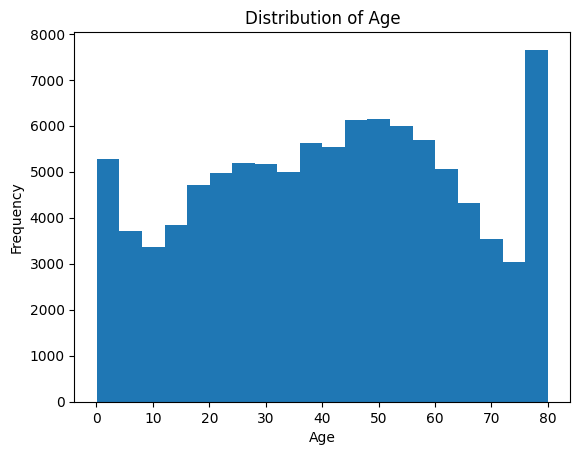

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("age").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Distribution of Age")
plt.show()

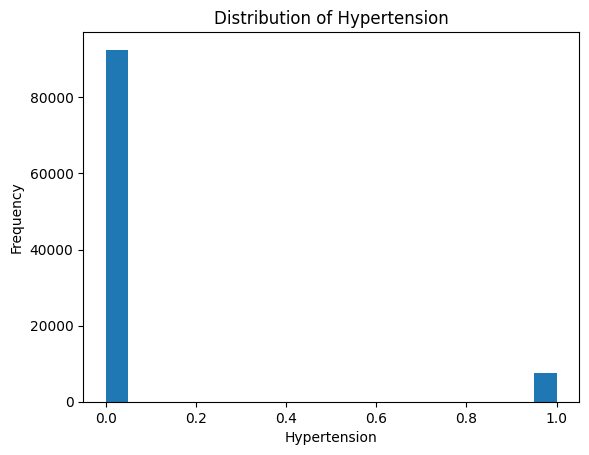

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("hypertension").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("Hypertension")
plt.ylabel("Frequency")
plt.title("Distribution of Hypertension")
plt.show()

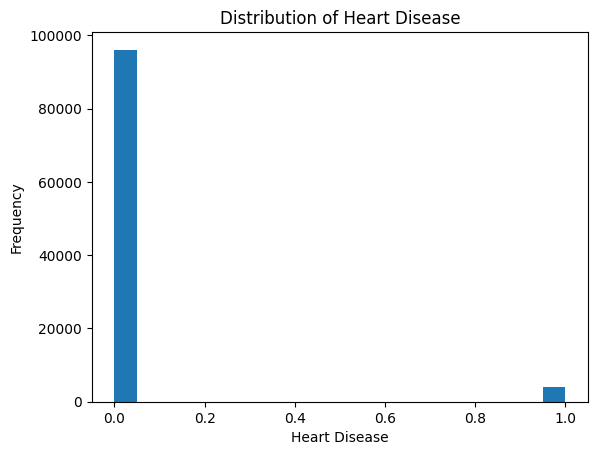

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("heart_disease").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("Heart Disease")
plt.ylabel("Frequency")
plt.title("Distribution of Heart Disease")
plt.show()

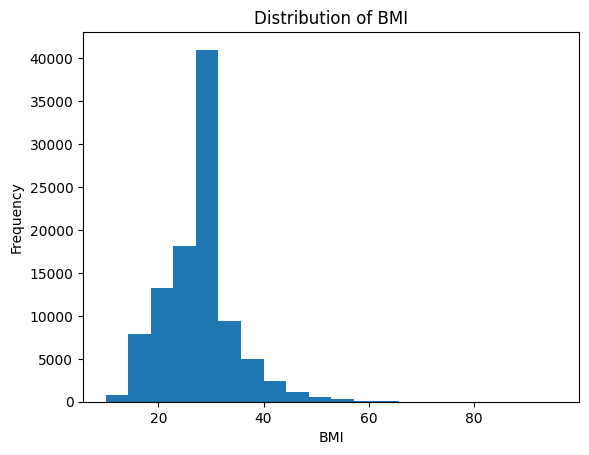

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("bmi").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("BMI")
plt.ylabel("Frequency")
plt.title("Distribution of BMI")
plt.show()

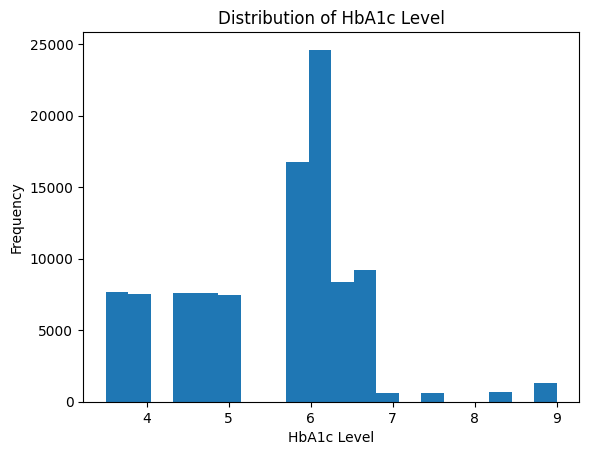

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("HbA1c_level").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("HbA1c Level")
plt.ylabel("Frequency")
plt.title("Distribution of HbA1c Level")
plt.show()

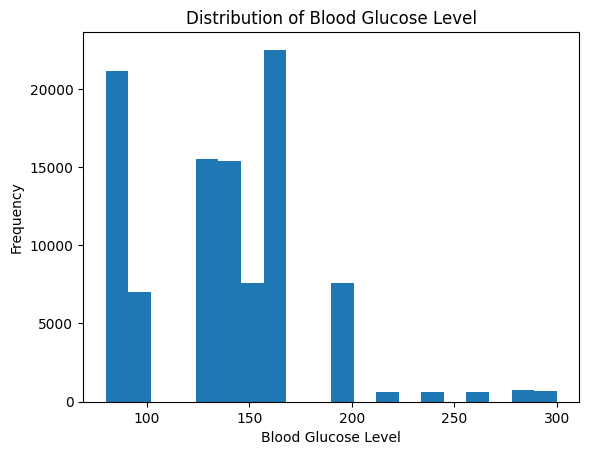

In [ ]:
import matplotlib.pyplot as plt

age_data = df.select("blood_glucose_level").toPandas()
plt.hist(age_data, bins=20)
plt.xlabel("Blood Glucose Level")
plt.ylabel("Frequency")
plt.title("Distribution of Blood Glucose Level")
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()
quantiles = df.approxQuantile("age", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_data = df.filter((col("age") >= lower_bound) & (col("age") <= upper_bound))
filtered_data = df.filter(expr("age >= {0} AND age <= {1}".format(lower_bound, upper_bound)))
filtered_data.show()
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|         

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()
quantiles = df.approxQuantile("hypertension", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
filtered_data = df.filter((col("hypertension") >= lower_bound) & (col("hypertension") <= upper_bound))
filtered_data = df.filter(expr("hypertension >= {0} AND hypertension <= {1}".format(lower_bound, upper_bound)))
filtered_data.show()
spark.stop()

Py4JJavaError: ignored

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create a Spark session
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()

# Load the data
df = spark.read.csv("Diabetes.csv", header=True, inferSchema=True)

# Calculate quartiles and IQR
quantiles = df.approxQuantile("heart_disease", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Define upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
filtered_data = df.filter((col("heart_disease") >= lower_bound) & (col("heart_disease") <= upper_bound))

# Alternatively, you can use an SQL expression for filtering
filtered_data = df.filter(expr("heart_disease >= {0} AND heart_disease <= {1}".format(lower_bound, upper_bound)))

# Show the filtered data
filtered_data.show()

# Stop the Spark session
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|            0|27.32|        5.0|                100|       0|
|53.0|           0|            0|27.32|        6.1|                 85|       0|
|54.0|           0|         

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create a Spark session
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()

# Load the data
df = spark.read.csv("Diabetes.csv", header=True, inferSchema=True)

# Calculate quartiles and IQR
quantiles = df.approxQuantile("bmi", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Define upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
filtered_data = df.filter((col("bmi") >= lower_bound) & (col("bmi") <= upper_bound))

# Alternatively, you can use an SQL expression for filtering
filtered_data = df.filter(expr("bmi >= {0} AND bmi <= {1}".format(lower_bound, upper_bound)))

# Show the filtered data
filtered_data.show()

# Stop the Spark session
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|         

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create a Spark session
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()

# Load the data
df = spark.read.csv("Diabetes.csv", header=True, inferSchema=True)

# Calculate quartiles and IQR
quantiles = df.approxQuantile("HbA1c_level", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Define upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
filtered_data = df.filter((col("HbA1c_level") >= lower_bound) & (col("HbA1c_level") <= upper_bound))

# Alternatively, you can use an SQL expression for filtering
filtered_data = df.filter(expr("HbA1c_level >= {0} AND HbA1c_level <= {1}".format(lower_bound, upper_bound)))

# Show the filtered data
filtered_data.show()

# Stop the Spark session
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|         

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr

# Create a Spark session
spark = SparkSession.builder.appName("Outlier Removal").getOrCreate()

# Load the data
df = spark.read.csv("Diabetes.csv", header=True, inferSchema=True)

# Calculate quartiles and IQR
quantiles = df.approxQuantile("blood_glucose_level", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Define upper and lower bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Remove outliers
filtered_data = df.filter((col("blood_glucose_level") >= lower_bound) & (col("blood_glucose_level") <= upper_bound))

# Alternatively, you can use an SQL expression for filtering
filtered_data = df.filter(expr("blood_glucose_level >= {0} AND blood_glucose_level <= {1}".format(lower_bound, upper_bound)))

# Show the filtered data
filtered_data.show()

# Stop the Spark session
spark.stop()

+----+------------+-------------+-----+-----------+-------------------+--------+
| age|hypertension|heart_disease|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+----+------------+-------------+-----+-----------+-------------------+--------+
|80.0|           0|            1|25.19|        6.6|                140|       0|
|54.0|           0|            0|27.32|        6.6|                 80|       0|
|28.0|           0|            0|27.32|        5.7|                158|       0|
|36.0|           0|            0|23.45|        5.0|                155|       0|
|76.0|           1|            1|20.14|        4.8|                155|       0|
|20.0|           0|            0|27.32|        6.6|                 85|       0|
|44.0|           0|            0|19.31|        6.5|                200|       1|
|79.0|           0|            0|23.86|        5.7|                 85|       0|
|42.0|           0|            0|33.64|        4.8|                145|       0|
|32.0|           0|         

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load the preprocessed data from a CSV file using pandas
data = pd.read_csv("Diabetes.csv")

# Split the data into features (X) and target variable (y)
X = data.drop("diabetes", axis=1)
y = data["diabetes"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the logistic regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Make predictions on the test data
predictions = lr.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 95.88%


In [ ]:
import numpy as np
import tensorflow as tf

# Load and preprocess the data
data = np.loadtxt('Diabetes.csv', delimiter=',', skiprows=1)
X = data[:, :-1]
y = data[:, -1]

# Normalize the features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Split the data into training and test sets
split = int(0.7 * len(data))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Define the ANN model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Epoch 1/10
2188/2188 [==============================] - 6s 2ms/step - loss: 0.1252 - accuracy: 0.9583
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0956 - accuracy: 0.9671
Epoch 3/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0894 - accuracy: 0.9693
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0870 - accuracy: 0.9700
Epoch 5/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0854 - accuracy: 0.9710
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0851 - accuracy: 0.9710
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0845 - accuracy: 0.9713
Epoch 8/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.0842 - accuracy: 0.9711
Epoch 9/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0839 - accuracy: 0.9714
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 0.0804 

In [ ]:
df1=pd.read_csv(r"Diabetes.csv")
df1

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
0,80.0,0,1,25.19,6.6,140,0
1,54.0,0,0,27.32,6.6,80,0
2,28.0,0,0,27.32,5.7,158,0
3,36.0,0,0,23.45,5.0,155,0
4,76.0,1,1,20.14,4.8,155,0
...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,6.2,90,0
99996,2.0,0,0,17.37,6.5,100,0
99997,66.0,0,0,27.83,5.7,155,0
99998,24.0,0,0,35.42,4.0,100,0


In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler



# Split the dataset into input features (X) and target variable (y)
X = df1.drop('diabetes', axis=1)  # Assuming 'diabetes' is the target column
y = df1['diabetes']

# Perform feature scaling (optional but often beneficial for logistic regression)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Create a LogisticRegression instance
lr = LogisticRegression()

# Start measuring the elapsed time
start_time = time.time()

# Fit the Logistic Regression model
lr.fit(X_train, y_train)

# Stop measuring the elapsed time
elapsed_time = time.time() - start_time

# Make predictions on the test set
y_pred = lr.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the elapsed time and accuracy
print("Elapsed time: {:.2f} seconds".format(elapsed_time))
print("Accuracy: {:.2f}%".format(accuracy * 100))


Elapsed time: 0.19 seconds
Accuracy: 96.13%


In [ ]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


n_features = X.shape[1]  # Replace X with your input feature matrix

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(n_features,)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Start measuring the elapsed time
start_time = time.time()

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

# Stop measuring the elapsed time
elapsed_time = time.time() - start_time

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)

# Print the evaluation results and elapsed time
print("Loss: {:.4f}".format(loss))
print("Accuracy: {:.2%}".format(accuracy))
print("Elapsed time: {:.2f} seconds".format(elapsed_time))


Epoch 1/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.1566 - accuracy: 0.9461
Epoch 2/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1120 - accuracy: 0.9615
Epoch 3/10
2188/2188 [==============================] - 5s 2ms/step - loss: 0.1063 - accuracy: 0.9642
Epoch 4/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.1008 - accuracy: 0.9663
Epoch 5/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0954 - accuracy: 0.9681
Epoch 6/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0909 - accuracy: 0.9693
Epoch 7/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0880 - accuracy: 0.9704
Epoch 8/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0861 - accuracy: 0.9709
Epoch 9/10
2188/2188 [==============================] - 4s 2ms/step - loss: 0.0852 - accuracy: 0.9709
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 0.0846 